In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pygad
import logging
import random
from collections import Counter
import seaborn as sns
import scipy

In [4]:
arr = pd.read_csv("phylo.csv",
                 delimiter=",")
display(arr)

,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
0,1,1,at1g01040.2,2173.635205,1911.200145,1152.555283,1291.422445,1000.252931,962.977223,1696.427421
1,2,1,at1g01050.1,1501.014084,1817.308557,1665.308874,1564.761244,1496.320663,1114.643547,1071.655487
2,3,1,at1g01070.1,1212.792724,1233.002267,939.200046,929.619501,864.218009,877.206001,894.818917
3,4,1,at1g01080.2,1016.920321,936.383717,1181.338144,1329.473434,1392.642854,1287.974590,861.260488
4,5,1,at1g01090.1,11424.566680,16778.168460,34366.649350,39775.640530,56231.568920,66980.367330,7772.561656
...,...,...,...,...,...,...,...,...,...,...
25255,25256,12,at5g67200.1,721.139701,731.211686,788.833156,815.185775,871.509726,809.404700,749.102579
25256,25257,12,at5g67245.1,1132.810160,1145.611552,1030.842523,1142.514730,1175.351616,985.904374,1147.261206
25257,25258,12,at5g67280.1,731.678348,748.688731,705.033813,622.710117,730.698691,864.307779,774.050852
25258,25259,12,at5g67380.1,14725.097780,2426.968469,2463.236828,2395.512964,1847.669032,1943.984418,5137.928045


In [5]:
ex_data = arr[["Zygote", "Quadrant","Globular","Heart","Torpedo","Bent","Mature"]]


In [6]:
var_ex = ex_data.var(axis=1)/ex_data.mean(axis=1) 
age_weighted = ex_data.mul(arr["Phylostratum"], axis=0)
perc = 1
high_var_ind =  np.argsort(var_ex)[-round(len(var_ex) * perc):]
low_var_ind =  np.argsort(var_ex)[:-round(len(var_ex) * perc)]


In [7]:
high_var_w = age_weighted.iloc[high_var_ind,:]
high_var = ex_data.iloc[high_var_ind,:]
low_var_w = age_weighted.iloc[low_var_ind,:]
low_var = ex_data.iloc[low_var_ind,:]

high_var_w_n = high_var_w.to_numpy()
high_var_n = high_var.to_numpy()
low_var_w_sum = low_var_w.sum(axis=0).to_numpy()
low_var_sum = low_var.sum(axis=0).to_numpy()

In [154]:
def get_removed_genes_from_solution(solution):
    return arr.iloc[high_var.index.values[np.where(solution == 0)[0]],:]


In [212]:
def flat_line_test_g_dist(expres_data,rounds):
    ex = expres_data.copy()
    ex_ex = ex.iloc[:, 3:]
    phil = ex['Phylostratum']
    variances = []
    for _ in range(rounds):
        perm = np.random.permutation(phil)
        weighted = ex_ex.mul(perm, axis=0)
        avg = weighted.sum(axis=0)/ex_ex.sum(axis=0)
        variances.append(np.var(avg))
    print(variances)
    shape, loc, scale = scipy.stats.gamma.fit(variances)
    return scipy.stats.gamma(shape, scale=scale)




In [215]:
gamma = flat_line_test_g_dist(arr,10000)

[0.0005419545617487096, 0.00032106300278359715, 0.00047270438400585696, 0.0010162320265832525, 0.0012055820456154966, 0.0005922039543919065, 0.00023007252134408113, 0.0029873325897906014, 0.001256730112411278, 0.0003975455130310148, 0.00014504679190322373, 0.0014566153757234967, 0.0017217063101989528, 0.0004019993590293161, 0.0007258780172116583, 0.0004372530151015238, 0.0009399843642788775, 0.0011394689878749167, 0.0001951072541660553, 0.000244955983038259, 0.0001207191796619249, 0.0009287401078574728, 0.0005727539081607508, 0.0028746865719871217, 0.00042351273981985216, 0.0006730815036828201, 0.0007800447943168227, 0.00017547027707024874, 0.00042404806412244065, 0.00019926139608249412, 0.00023092181314723117, 0.0005191902934121429, 0.0007240049616338275, 0.00019616958902976986, 0.0005086553477417746, 0.003270732979039344, 0.0009320543274484334, 0.0005187680001510493, 0.0010166816943163771, 0.00015822068699380005, 0.00023491039651827778, 0.00023492456739684318, 0.00017039201145011614,

In [450]:
def fitness_batch(ga_instance, solution, solution_idx):
    up = np.add(solution.dot(high_var_w_n),np.tile(low_var_w_sum,(solution.shape[0],1)))
    down = np.add(np.tile(low_var_sum,(solution.shape[0],1)), solution.dot(high_var_n))
    avgs = np.divide(up,down)
    num_not_removed = np.sum(solution,axis = 1)
    num_removed = solution.shape[1] - num_not_removed
    fitt = (1 - gamma.cdf(np.var(avgs,axis=1)) + (num_not_removed/solution.shape[1])) * np.multiply(num_removed < 600,1)
    return fitt     
    

In [402]:
def var_batch(solution):
    up = np.add(solution.dot(high_var_w_n),np.tile(low_var_w_sum,(solution.shape[0],1)))
    down = np.add(np.tile(low_var_sum,(solution.shape[0],1)), solution.dot(high_var_n))
    avgs = np.divide(up,down)
    return np.var(avgs,axis=1)

In [9]:
def fitness(ga_instance, solution, solution_idx):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    
    return - np.var(avgs) + ((sum(solution)/len(solution))**2)*1.e-1
    

In [78]:
def get_ex_hist(removed_genes):
    variances = removed_genes.iloc[:, 2:].var(axis=1)
    variances_df = pd.DataFrame(data={'removed': variances, 'removed_cv': variances/removed_genes.iloc[:, 2:].mean(axis=1),'all': ex_data.var(axis=1),'all_cv': ex_data.var(axis=1)/ex_data.mean(axis=1)})
    sns.histplot(data=variances_df,x="removed",stat="density",binrange=(0,10000),fill=False,common_norm=False,bins=30,label="removed")
    sns.histplot(data=variances_df,x="all",stat="density",binrange=(0,10000),fill=False,common_norm=False,bins=30,label="all")
    plt.legend()

In [102]:
def print_curve(solution,label=None):
    up = np.add(high_var_w.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy(),low_var_w_sum)
    down = np.add(low_var_sum, high_var.iloc[np.where(solution == 1)[0],:].sum(axis=0).to_numpy())
    avgs = np.divide(up,down)
    print(np.var(avgs))
    plt.ylim(3, 3.8)
    plt.plot(list(range(7)),avgs,'-o',label=label)
    if label:
        plt.legend()
    

In [152]:
def get_sol_from_indices(indices):
    ones = np.ones_like(solution)
    ones[indices] = 0
    return ones

In [47]:
def create_population(size,init_num_removed):
    return np.array([random.choices([0,1], weights=(1, high_var.shape[0]/init_num_removed), k=high_var.shape[0]) for _  in range(size)])

0.009837646583158657


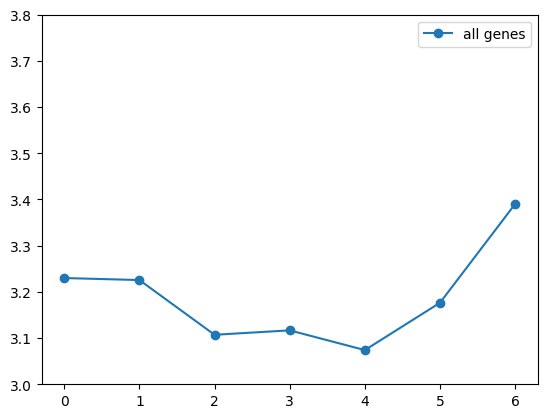

In [12]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [14]:
solution = None

In [521]:
def mutation_func(offspring, ga_instance):
    for chromosome_idx in range(offspring.shape[0]):
        if random.random() < ga_instance.mutation_probability:
            randomlist = random.sample(range(offspring.shape[1]), 10)
            randomlist1 = random.sample(range(offspring.shape[1]), 5)
            for ind in randomlist:
                offspring[chromosome_idx][ind] = (offspring[chromosome_idx][ind] + 1) % 2
            offspring[chromosome_idx][randomlist1] = 0

    return offspring


In [542]:
"""
level = logging.DEBUG
name = 'logfile.txt'

logger = logging.getLogger(name)
logger.setLevel(level)


console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_format = logging.Formatter('%(message)s')
console_handler.setFormatter(console_format)
logger.addHandler(console_handler)
"""
def run_GA():
    #prev_solution = solution
    num_threads = 6
    population = create_population(150,30)

    ga_instance = pygad.GA(num_generations=330,
                        num_parents_mating=35,
                        fitness_func=fitness_batch,
                        fitness_batch_size=population.shape[0],
                        initial_population=population,
                        mutation_type=mutation_func,
                        crossover_probability=0.07,
                        mutation_probability=0.2,
                        init_range_low=0,
                        init_range_high=2,
                        gene_type=int,
                        crossover_type="scattered",
                        parallel_processing=["thread", num_threads],
                        save_best_solutions=True,
                        keep_elitism=1
                        )

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    return ga_instance

In [536]:
ga_instance = run_GA()

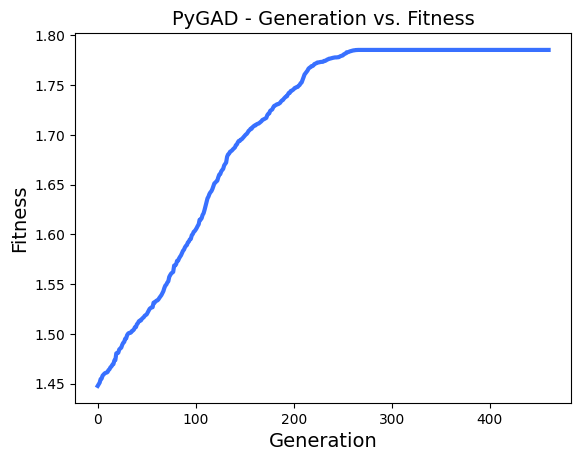

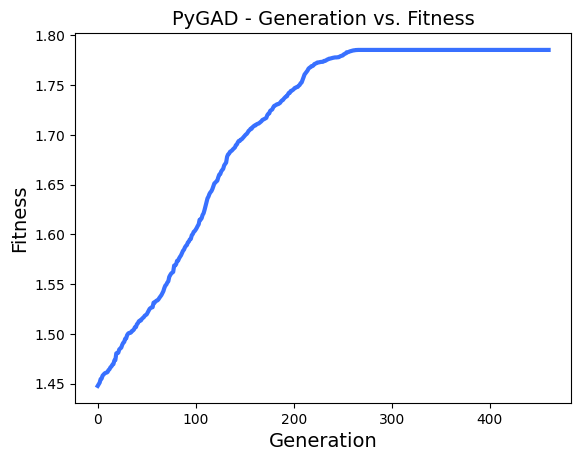

In [553]:
solutions[1].plot_fitness()

In [543]:
solutions = []
for i in range(2):
    solutions.append(run_GA())

In [396]:
solutions

In [544]:
sols = np.array([x.best_solution()[0] for x in solutions])

In [545]:
var_batch(sols)

array([3.51790681e-06, 2.78313031e-06])

2.0015346104711186e-05


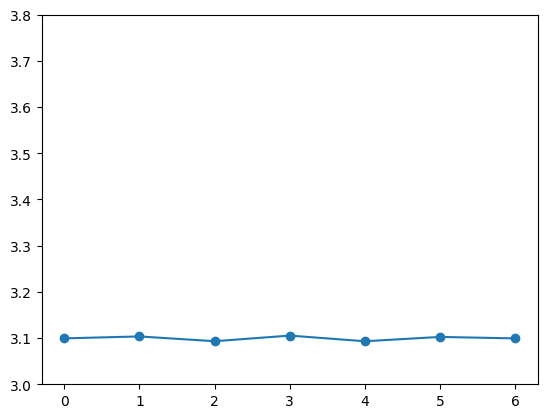

In [538]:
print_curve(ga_instance.best_solution()[0])

In [539]:
len(np.where(solution == 0)[0])

999

In [540]:
len(np.where(ga_instance.best_solution()[0] == 0)[0])

588

In [242]:
com_rem_arr = np.logical_and(solution == 0, solutions[0][0] == 0).sum()

In [244]:
com_rem_arr

124

In [224]:
stats = solutions[0][1]

In [219]:
solutions = np.array(solutions)

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_89005/1415263720.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  solutions = np.array(solutions)


0.0012288837726360591


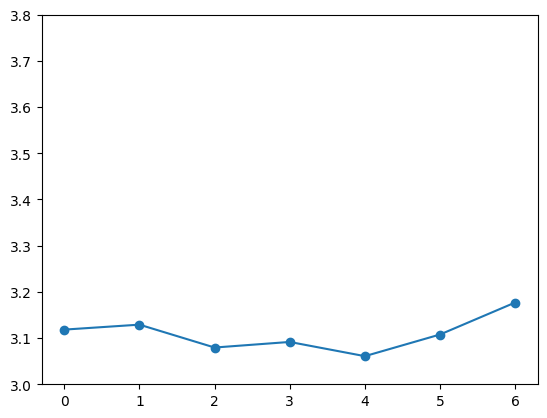

In [169]:
common_removed = arr.iloc[high_var.index.values[np.logical_and(solution == 0, prev_solution == 0)],:]
com_rem_arr = np.logical_or(solution == 1, prev_solution == 1)
print_curve(com_rem_arr)

In [398]:
mul_targ = solutions.shape[0] -  solutions.sum(axis=0)[((solutions.shape[0] -  solutions.sum(axis=0)) > 3)]
mul_targ = get_sol_from_indices(mul_targ)
removed_mul_targ = get_removed_genes_from_solution(mul_targ)
print_curve(mul_targ)

AttributeError: 'list' object has no attribute 'shape'

In [226]:
num_of_removed = solutions.shape[1] -  solutions.sum(axis=1)
num_of_removed

TypeError: unsupported operand type(s) for +: 'int' and 'GA'

In [548]:
np.array(sols).shape[1] - np.array(sols).sum(axis=1)

array([590, 593])

In [549]:
common = set.intersection(*map(set,(np.where(solution == 0)[0] for solution in sols)))
common

{1013,
 15617,
 15775,
 19463,
 20929,
 21213,
 21536,
 22029,
 22056,
 22129,
 22239,
 22314,
 22392,
 22554,
 22558,
 23143,
 23466,
 23655,
 23680,
 23698,
 23705,
 23708,
 23730,
 23846,
 23927,
 23992,
 23999,
 24050,
 24055,
 24110,
 24193,
 24247,
 24285,
 24300,
 24325,
 24347,
 24348,
 24359,
 24431,
 24488,
 24497,
 24516,
 24533,
 24548,
 24550,
 24551,
 24574,
 24591,
 24617,
 24619,
 24667,
 24669,
 24676,
 24683,
 24703,
 24716,
 24717,
 24723,
 24726,
 24735,
 24764,
 24773,
 24777,
 24786,
 24800,
 24814,
 24824,
 24834,
 24848,
 24851,
 24857,
 24897,
 24907,
 24924,
 24945,
 24947,
 24952,
 24954,
 24969,
 24975,
 24985,
 24999,
 25015,
 25019,
 25043,
 25053,
 25063,
 25083,
 25091,
 25093,
 25094,
 25099,
 25106,
 25107,
 25127,
 25135,
 25136,
 25140,
 25144,
 25146,
 25153,
 25160,
 25161,
 25169,
 25176,
 25181,
 25183,
 25186,
 25204,
 25205,
 25207,
 25213,
 25214,
 25239,
 25241,
 25245,
 25246,
 25247,
 25251,
 25254}

0.0011545882304911683


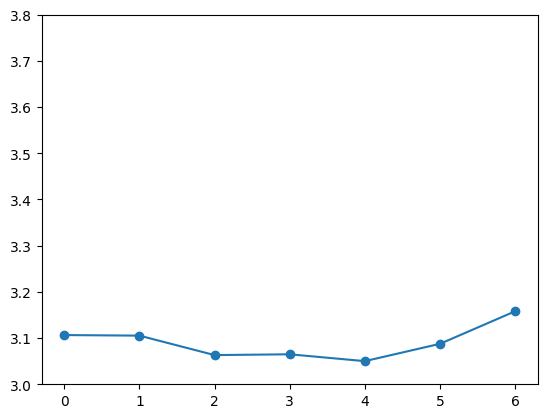

In [551]:
print_curve(get_sol_from_indices(list(common)))

5.1082210666394055e-05
377
0.014924782264449724


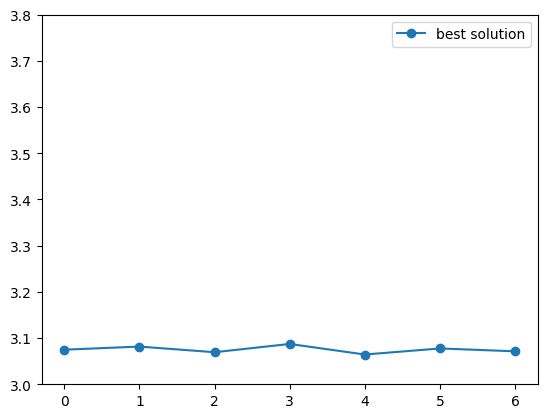

In [181]:
print_curve(solutions[2],label="best solution")
print(len(np.where(solution == 0)[0]))
print(len(np.where(solution == 0)[0])/len(solution))


In [57]:
# in how many generations new best fitness emerged
print(len(set(ga_instance.best_solutions_fitness)))

161


In [138]:
len(ga_instance.best_solutions_fitness)

181

In [272]:

lens = len(solution) - np.sum(np.array(ga_instance.solutions),axis = 1)
fit =fitness_batch(None,np.array(ga_instance.solutions),None)
fit_ind = np.argsort(fitness_batch(None,np.array(ga_instance.solutions),None))
plt.scatter(lens,fit, s=0.1)

AxisError: axis 1 is out of bounds for array of dimension 1

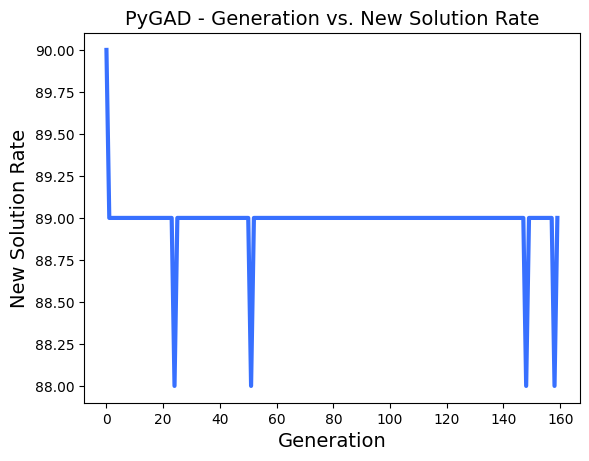

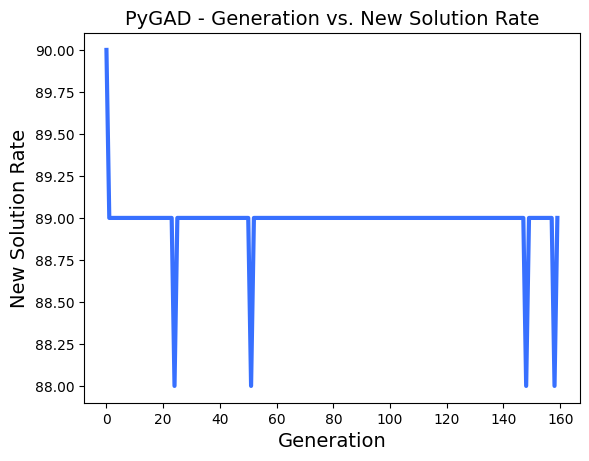

In [191]:
ga_instance.plot_new_solution_rate()

0.009837646583158657


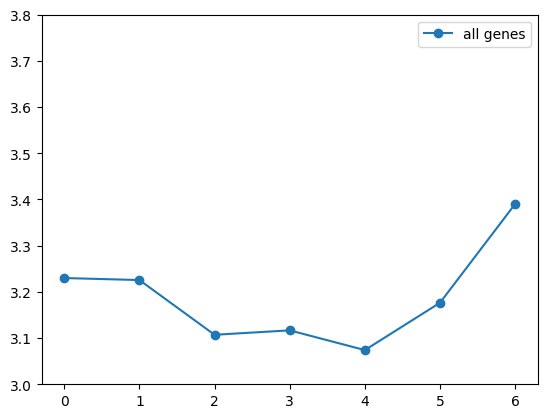

In [532]:
print_curve(np.ones(high_var.shape[0]), label="all genes")

In [140]:
comm = get_removed_genes_from_solution(ones)

In [42]:
removed_genes =  arr.iloc[high_var.index.values[np.where(solution == 0)[0]],:]

display(removed_genes)

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_89005/2635158219.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances = removed_genes.iloc[:, 2:].var(axis=1)


,Unnamed: 0,Phylostratum,GeneID,Zygote,Quadrant,Globular,Heart,Torpedo,Bent,Mature
8097,8098,1,at5g40020.1,685.724723,680.611796,671.045301,681.262277,705.428063,658.706627,685.322192
4800,4801,1,at3g26780.1,661.913185,698.076319,682.836045,668.451217,672.081580,654.825536,680.219241
6634,6635,1,at4g32170.1,741.239790,755.183286,726.176003,765.633587,773.604256,746.520416,757.320410
25056,25057,12,at5g38240.1,621.815292,609.621129,598.470127,637.846169,617.250087,608.082312,596.378559
8903,8904,1,at5g61910.4,748.406405,742.488793,734.041345,737.110101,738.559992,724.769498,697.309005
...,...,...,...,...,...,...,...,...,...,...
21826,21827,8,at2g42560.1,2457.993370,835.481543,834.124473,760.883619,726.684578,3752.426116,68490.545990
23539,23540,12,at1g07500.1,2236.167648,872.144043,816.071814,852.034298,824.409176,1904.961405,67841.771130
21446,21447,7,at1g07985.1,2962.440546,904.682744,899.162118,814.911574,784.399822,2371.147397,71635.640930
20234,20235,6,at1g75830.1,4458.236715,998.800310,986.139617,933.795325,814.189089,1335.810446,72600.065370


<AxesSubplot: xlabel='Phylostratum', ylabel='Count'>

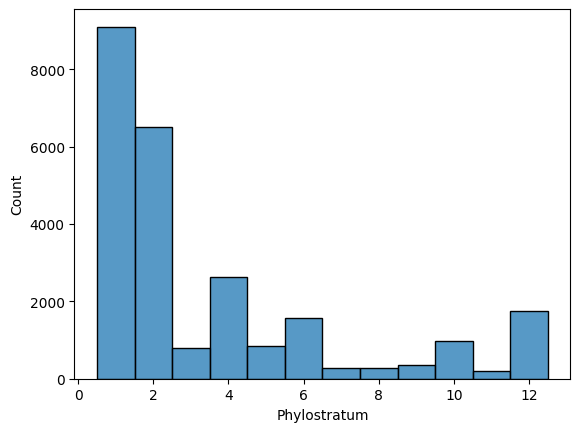

In [43]:
sns.histplot(data=arr,x="Phylostratum",discrete=True)

<BarContainer object of 12 artists>

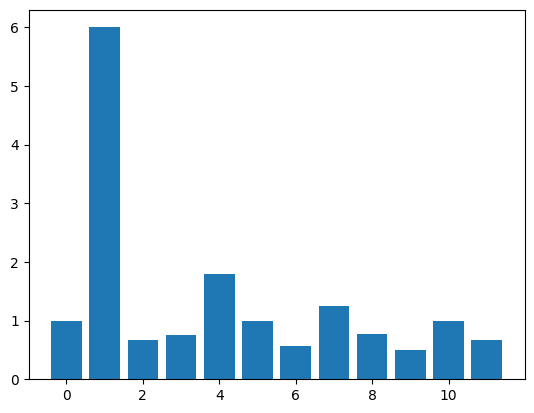

In [44]:
dff = np.array(list(Counter(removed_genes["Phylostratum"])))/np.array(list(Counter(arr["Phylostratum"])))
plt.bar(range(len(dff)),dff)

/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_89005/1673284101.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances = removed_genes.iloc[:, 2:].var(axis=1)
/var/folders/pw/r8s9dk9x4z56sfjh5qm3t8gw0002n8/T/ipykernel_89005/1673284101.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  variances_df = pd.DataFrame(data={'removed': variances, 'removed_cv': variances/removed_genes.iloc[:, 2:].mean(axis=1),'all': ex_data.var(axis=1),'all_cv': ex_data.var(axis=1)/ex_data.mean(axis=1)})


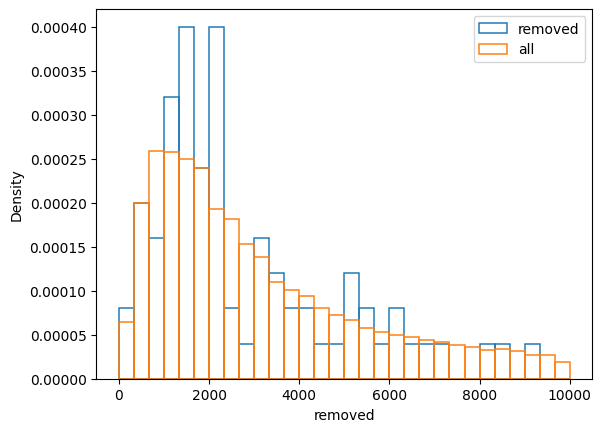

In [187]:
get_ex_hist(get_removed_genes_from_solution(solutions[1]))

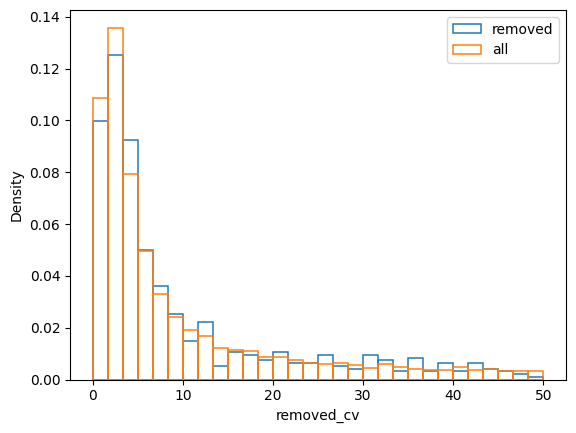

In [278]:
sns.histplot(data=variances_df,x="removed_cv",stat="density",binrange=(0,50),fill=False,common_norm=False,bins=30,label="removed")
sns.histplot(data=variances_df,x="all_cv",stat="density",binrange=(0,50),fill=False,common_norm=False,bins=30,label="all")
plt.legend()
